In [67]:
import pandas as pd

df = pd.read_csv("../data/amex_complaints_sentiment.csv")

print("Unique labels in consumer_disputed?:", df['consumer_disputed?'].unique())


Unique labels in consumer_disputed?: ['Unknown' 'Yes' 'No']


In [68]:
df['disputed_flag'] = df['consumer_disputed?'].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)

print("Class distribution:")
print(df['disputed_flag'].value_counts())


Class distribution:
disputed_flag
0    4906
1     503
Name: count, dtype: int64


In [69]:
features = ['vader_sentiment', 'submitted_via', 'issue']
X = df[features]
y = df['disputed_flag']

X_encoded = pd.get_dummies(X, columns=['submitted_via', 'issue'])

print("Encoded feature shape:", X_encoded.shape)


Encoded feature shape: (5409, 46)


In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (4327, 46)
Test set size: (1082, 46)


In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2%}")
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Not Disputed", "Disputed"]))


Model Accuracy: 88.72%
Classification Report:
               precision    recall  f1-score   support

Not Disputed       0.94      0.94      0.94      1001
    Disputed       0.27      0.30      0.28        81

    accuracy                           0.89      1082
   macro avg       0.61      0.62      0.61      1082
weighted avg       0.89      0.89      0.89      1082



In [72]:
import joblib

joblib.dump(model, "../outputs/escalation_model.pkl")
print("Model saved to: ../outputs/escalation_model.pkl")


Model saved to: ../outputs/escalation_model.pkl


Top 10 Features Driving Disputes:
                                                  Feature  Importance
0                                         vader_sentiment    0.681961
39                                          issue_Rewards    0.049196
9                                  issue_Billing disputes    0.030602
3                         issue_Advertising and marketing    0.030210
29                                            issue_Other    0.025249
37  issue_Problem with a purchase shown on your statement    0.015805
30               issue_Other features, terms, or problems    0.010671
24                            issue_Getting a credit card    0.009812
2                              issue_APR or interest rate    0.009696
20            issue_Customer service / Customer relations    0.008934


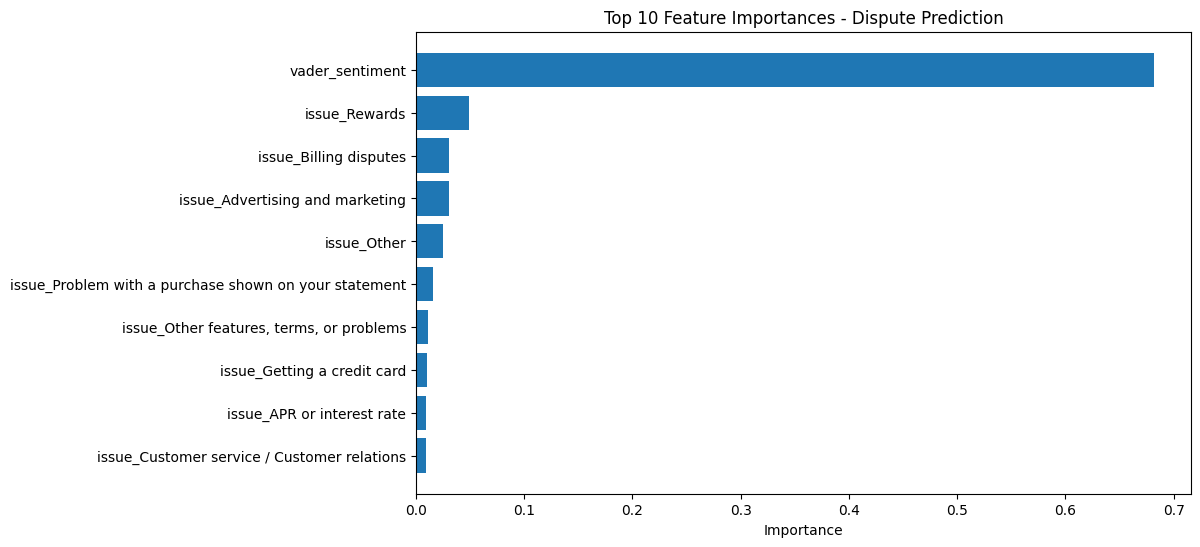

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X_encoded.columns

feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("Top 10 Features Driving Disputes:")
print(feat_imp_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df.head(10)['Feature'], feat_imp_df.head(10)['Importance'])
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - Dispute Prediction")
plt.xlabel("Importance")
plt.show()


In [74]:
sample_df = X_test.copy()
sample_df['Actual_Dispute'] = y_test
sample_df['Predicted_Dispute'] = y_pred
sample_df['consumer_complaint_narrative'] = df.loc[sample_df.index, 'consumer_complaint_narrative']
sample_df['sentiment_label'] = df.loc[sample_df.index, 'sentiment_label']
sample_df['vader_sentiment'] = df.loc[sample_df.index, 'vader_sentiment']

pd.set_option('display.max_colwidth', None) 
sample_display = sample_df.sample(5, random_state=42)

print("Sample Predictions:")
display(sample_display[['consumer_complaint_narrative', 'sentiment_label', 'vader_sentiment', 'Actual_Dispute', 'Predicted_Dispute']])


Sample Predictions:


,consumer_complaint_narrative,sentiment_label,vader_sentiment,Actual_Dispute,Predicted_Dispute
4600,"I have twice requested on recorded phone lines for the EXACT ARRANGED AGREEMENT of debt collection. I do not have the date of first request, but 2nd request was XX/XX/2023. Department is nothing but hostile, denies not sending it, when they have never sent it. American Express is willfully withholding information and documents",positive,0.7289,0,0
272,"Dear American Express, I am writing to formally express my dissatisfaction with the handling of the Companion Certificate associated with my American Express XXXX XXXX XXXX XXXX XXXX. I was informed that I would receive this certificate, but despite several interactions with your team, it has yet to arrive. \n\nBelow is a transcript of a recent chat with your representatives : Amex : "" Great. I can see the Companion certificate issuance month is XXXX, so please rest assured it will be issued after XXXX to XXXX weeks. However, this is the maximum time. It will be issued after the XX/XX/year>, statement closing date. '' Me : "" Yes, I understand that from the last representative. However, I wanted to clarify what under process means. Has it been under process for XXXX weeks now, or just a few days? As I mentioned before, I know XXXX others who have the card and they received their certificates immediately when their annual fee hit. Why hasnt mine been issued yet? '' Amex : "" Under process means the XXXX team will check and issue the certificate accordingly. Since this benefit is provided by the XXXX team, for more details you need to contact XXXX. As we are from the card servicing team, we can only check the issuance month. '' Me : "" I already contacted XXXX, and as I mentioned, they have not received anything from your side. '' Amex : "" Please rest assured, you will receive the certificate. It is taking time, but after the statement closing date, you will receive it. You can contact us if you have not received it by XX/XX/XXXX. '' Despite being repeatedly assured that the certificate would be issued, I have yet to receive it, and this ongoing delay is unacceptable. Furthermore, other cardholders have received their certificates promptly, so its unclear why my situation is different. I believe I have been patient, but I expect swift action to resolve this matter. \n\nIf this issue is not resolved promptly, I will consider escalating the matter further. \n\nThank you for your attention to this matter, and I look forward to your immediate response. \n\nSincerely, XXXX XXXX",positive,0.9816,0,0
3908,"i received a letter from American Express saying "" I have been qualified and enrolled in the Select & pay Later feature .... If you do not wan to be enrolled in Select & Pay Later, please contact us ... "" If you cancel you will not be able request this program in the future back. \nThey list the charges at 18.49 % APR. \nThis is was in a letter that could have been easily thrown out. This is not something I asked for. This is a way they can trick customers and force them to pay high interest charges when they sign up for credit card which is designed to have the balance paid off at the end of the month. This is predatory behavior and should be stopped. They need to ask your permission to enroll in the program, not you must call in to cancel something you did not ask to be enrolled in.",neutral,-0.0516,0,0
2024,"Issue Summary : Card Cancellations : My credit cards have been suddenly cancelled on three distinct XXXX XXXXXXXX XXXX XXXXXX/XX/2023, and XX/XX/2023. \n\nAnnual Fees : Following each card reissuance, I have been subjected to the levy of annual fees, precipitating multiple payments within one year. \n\nDetailed Account of Events : Cancellation on XX/XX/2023 : Return Payments : Instances occurred on XX/XX/2023, XX/XX/2023, and XX/XX/2023, facilitated by XXXX XXXX. Unknown to me, payments were blocked due to an auto-pay arrangement initiated without my consent. Following its di

In [75]:
correct_disputes = X_test.copy()
correct_disputes['Actual_Dispute'] = y_test
correct_disputes['Predicted_Dispute'] = y_pred

correct_disputes = correct_disputes[(correct_disputes['Predicted_Dispute'] == 1)&(correct_disputes['Actual_Dispute'] == 1)]

correct_disputes['consumer_complaint_narrative'] = df.loc[correct_disputes.index, 'consumer_complaint_narrative']
correct_disputes['sentiment_label'] = df.loc[correct_disputes.index, 'sentiment_label']
correct_disputes['vader_sentiment'] = df.loc[correct_disputes.index, 'vader_sentiment']

pd.set_option('display.max_colwidth', None)
sample_correct_disputes = correct_disputes.sample(2, random_state=42)

print("Examples of Correctly Predicted Escalated Complaints:")
display(sample_correct_disputes[['consumer_complaint_narrative', 'sentiment_label', 'vader_sentiment', 'Actual_Dispute', 'Predicted_Dispute']])


Examples of Correctly Predicted Escalated Complaints:


,consumer_complaint_narrative,sentiment_label,vader_sentiment,Actual_Dispute,Predicted_Dispute
3724,"This is in essence the same case that was submitted/reported under ( XXXX and XXXX ) for XXXX XXXX. This complaint is specifically for American Express for similar reasons. We agreed to purchase a timeshare from XXXX XXXX if they purchased our XXXX timeshare. They failed to purchase our timeshare within the time required ( 60-days ) - it has been over 6 months. In the attachments much more detail is provided in the "" XXXX timeshare summary ''. American Express has sufficient information to reverse the charges but they are ignoring the evidence. XXXX XXXX needs to either purchase our XXXX timeshare as agreed or tell American Express to refund our money. \nFor XXXX XXXX to abide by the agreement they would need to purchase our property for the agreed to amount of {$100000.00}. Since they also agreed to refund the entire amount of the purchase of their property in the first XXXX we would also like those charges reversed on our credit card ( {$24000.00} ). At a very minimum the credit card charges should be reversed.",positive,0.9099,1,1
5108,"On XX/XX/2016 I applied and was approved for a Platinum Card with a sign up bonus of XXXX points under the condition that I spend $ XXXX in 3 months. I received the points XX/XX/2016. On XX/XX/2016 I contacted Amex customer service via chat ( screenshot provided ) and asked if me returning an item would cause me any issues with my sign up bonus of XXXX and asked for confirmation that I would get to keep my points without issue. The representative ( XXXX ) assured me that it would not cause any problems. \n\nThus, I was surprised to find that on XX/XX/2016 my XXXX sign up bonus was removed from my account. When contacting Amex, they transferred me to several different departments until giving me the reason that the points were removed because of "" returns ''. They then said started an investigation and put a hold on all of my remaining points in my account thus preventing me from using them during the holiday travel season. It has now been 2 months and I have received no response, my points have not been returned, and my account has been locked. I 've contacted Amex for a status update and they continue to give me the run around and transfer me to several departments until I get hung up on. \n\n*I 've attached a copy of my chat with the Amex customer service representative confirming that returning an item would not cause my points to be reversed. I 've also attached a copy of my statement showing the same charges shown in the chat to prove the chat was talking about the account mentioned.",positive,0.9621,1,1
